In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import copy
import os
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
from torchsummary import summary
from IPython.display import clear_output

seed = 0
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Configuration

In [3]:
start_date = datetime.now()
run_name = start_date.strftime("%Y-%m-%d_%H_%M_%S")
run_folder = os.path.join('results', run_name)
if not os.path.exists(run_folder):
    os.makedirs(run_folder)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda:6')
data_dir = 'data/data.csv'
batch_size = 2**8
training_data_proportion = 1 / 3
num_workers = 0
lr = 0.001
lr_scheduler_factor = 0.5
lr_scheduler_patience = 80
n_epochs = 1000
eval_step = 10000  # after how many data (not batch) seen the validation loss should be computed
fig_path = os.path.join(run_folder, f'{run_name}.png')

## Dataloader

In [4]:
class SpeciesAreaEnvData(Dataset):

    def __init__(self, data_dir, dtype=np.float32):
        SAE_data = pd.read_csv(data_dir)

        # Convert habitat_id to one hot encoding
        SAE_data = SAE_data.join(pd.get_dummies(SAE_data['habitat_id']))
        SAE_data = SAE_data.drop('habitat_id', axis=1)
        SAE_data = SAE_data.drop('partition', axis=1)
        self.columns_names = SAE_data.columns
        self.num_features = len(self.columns_names) - 2

        # Convert dataframe to array
        SAE_data = torch.Tensor(SAE_data.values.astype(dtype))

        # Scaling the species richness values
        # Warning: Here min and max are computed on the whole dataset, it should be computed only on the thaining set
        target_scaler = StandardScaler()
        log_species_richness = target_scaler.fit_transform(SAE_data[:, 0].reshape(-1, 1)).flatten()
        #log_species_richness = log_species_richness[torch.randperm(
        #    len(log_species_richness))]  # Shuffle targets for testing
        SAE_data[:, 0] = torch.Tensor(log_species_richness)

        self.SAE_data = SAE_data
        self.dtype = dtype
        self.dataset_length = len(SAE_data)

    def __getitem__(self, index):
        return self.SAE_data[index, 0], self.SAE_data[index, 1], self.SAE_data[index, 2:]

    def __len__(self):
        return self.dataset_length


## Dataset loading

In [5]:
SAE_dataloader = SpeciesAreaEnvData(data_dir)

training_set, validation_set = torch.utils.data.random_split(SAE_dataloader, [
    int(len(SAE_dataloader) * training_data_proportion),
    len(SAE_dataloader) - int(len(SAE_dataloader) * training_data_proportion)
])

#training_set.dataset.SAE_data = training_set.dataset.SAE_data.to(device)
#validation_set.dataset.SAE_data = validation_set.dataset.SAE_data.to(device)

training_loader = DataLoader(training_set,
                             shuffle=True,
                             batch_size=batch_size,
                             drop_last=False,
                             num_workers=num_workers)

validation_loader = DataLoader(validation_set,
                               shuffle=True,
                               batch_size=batch_size,
                               drop_last=False,
                               num_workers=num_workers)

print(f'{len(training_loader)} training batches with a total of {len(training_set)} data')
print(f'{len(validation_loader)} validation batches with a total of {len(validation_set)} data')

339 training batches with a total of 86665 data
678 validation batches with a total of 173330 data


## Data visualization

```python
data = {'log_species_richness': [], 'log_area': [], 'environmental_variables': []}
for val_batch_num, (log_species_richness, log_area, environmental_variables) in enumerate(validation_loader):
    data['log_species_richness'].append(log_species_richness.numpy())
    data['log_area'].append(log_area.numpy())
    data['environmental_variables'].append(environmental_variables.numpy())
data['log_species_richness'] = np.concat(data['log_species_richness'])
data['log_area'] = np.concat(data['log_area'])
data['environmental_variables'] = np.concat(data['environmental_variables'])
sns.kdeplot(x=data['log_species_richness'], y=data['log_area'], fill=True)
plt.show()

data = {'log_species_richness': [], 'log_area': [], 'environmental_variables': []}
for val_batch_num, (log_species_richness, log_area, environmental_variables) in enumerate(training_loader):
    data['log_species_richness'].append(log_species_richness.numpy())
    data['log_area'].append(log_area.numpy())
    data['environmental_variables'].append(environmental_variables.numpy())
data['log_species_richness'] = np.concat(data['log_species_richness'])
data['log_area'] = np.concat(data['log_area'])
data['environmental_variables'] = np.concat(data['environmental_variables'])
sns.kdeplot(x=data['log_species_richness'], y=data['log_area'], fill=True)
plt.show()
```

## Artificial neural network architecture

In [6]:
class FullyConnectedBatchNormBlock(nn.Module):

    def __init__(self, in_features, out_features):
        super(FullyConnectedBatchNormBlock, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.batch_norm = nn.BatchNorm1d(out_features)

    def forward(self, x):
        x = self.linear(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        return x


class SimpleNNBatchNorm(nn.Module):

    def __init__(self, num_features):
        super(SimpleNNBatchNorm, self).__init__()
        layer_sizes = [num_features, 64, 128, 256, 512, 256, 128]
        self.fully_connected_layers = nn.ModuleList(
            [FullyConnectedBatchNormBlock(in_f, out_f) for in_f, out_f in zip(layer_sizes[:-1], layer_sizes[1:])])
        self.last_fully_connected = nn.Linear(layer_sizes[-1], 2)

    def forward(self, environmental_variables):
        x = environmental_variables
        for fully_connected_layer in self.fully_connected_layers:
            x = fully_connected_layer(x)
        x = self.last_fully_connected(x)

        return x


class NNSAR(nn.Module):

    def __init__(self, num_features):
        super(NNSAR, self).__init__()
        self.nn = SimpleNNBatchNorm(num_features)

    def forward(self, log_area, environmental_variables):
        x = self.nn(environmental_variables)
        log_species_richness = x[:, 0] + log_area * x[:, 1]

        return log_species_richness

## Training

In [7]:
def update_plot(fig_filename):
    clear_output(wait=True)
    f, ax1 = plt.subplots()
    #ax2 = ax1.twinx()
    #plt.figure(figsize=(10, 6))
    ax1.plot(log_info['step'], log_info['validation_loss'], label='Validation loss')
    ax1.plot(log_info['step'], log_info['training_loss'], label='Training loss')
    ax1.set_xlabel('Data seen')
    ax1.set_ylabel('MSE loss')
    #plt.ylim(0, 10**math.ceil(np.log(np.max([log_info['validation_loss'][-1], log_info['training_loss'][-1]]))))
    #plt.ylim(0, 1)
    [ax1.axvline(x=e, color='g', linestyle='--', linewidth=1) for e in epoch_step]
    ax1.axvline(x=0, color='g', label='New epoch', linestyle='--', linewidth=1)
    ax1.legend()
    plt.grid()
    ax1.text(.03,
             .05,
             f'Lowest validation MSE: {best_validation_loss:.5f}',
             ha='left',
             va='top',
             transform=ax1.transAxes,
             bbox=dict(facecolor='white', edgecolor='lightgrey', boxstyle='round,pad=0.3', alpha=0.8))

    #ax2.plot(log_info['step'], log_info['lr_value'], label='Learning rate')
    #ax2.set_ylabel('Learning rate value')
    plt.yscale('log')
    f.tight_layout()
    plt.savefig(fig_filename)
    plt.show()

In [8]:
from xgboost import XGBRegressor

xgb_params = {
    "booster": "gbtree",
    "learning_rate": 0.05,
    "max_depth": 10,
    "lambda": 10,
    "objective": "reg:squarederror",
    "min_child_weight": 1.0,
    "tree_method": "hist",
}

target_train = training_set.dataset.SAE_data.numpy()[training_set.indices, 0]
features_train = training_set.dataset.SAE_data.numpy()[training_set.indices, 1:]

xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(features_train, target_train)

mse_train = np.mean((xgb_model.predict(features_train) - target_train)**2)

target_val = validation_set.dataset.SAE_data.numpy()[validation_set.indices, 0]
features_val = validation_set.dataset.SAE_data.numpy()[validation_set.indices, 1:]

mse_val = np.mean((xgb_model.predict(features_val) - target_val)**2)

print(f'MSE train: {mse_train:.5f}')
print(f'MSE validation: {mse_val:.5f}')

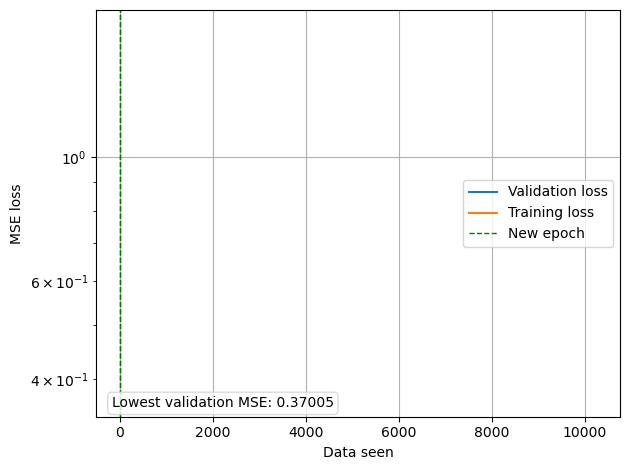

KeyboardInterrupt: 

In [ ]:
model = NNSAR(SAE_dataloader.num_features)
#model = nn.DataParallel(model)
model.to(device)
#model.apply(init_weights)
summary(model)
criterion = nn.MSELoss()
criterion.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, factor=lr_scheduler_factor, patience=lr_scheduler_patience)
log_info = {'step': [], 'training_loss': [], 'validation_loss': [], 'lr_value': []}
step = 0
running_training_loss = 0
running_validation_loss = 0
best_validation_loss = float('inf')
epoch_step = []
plt.ion()

for epoch in range(n_epochs):
    model.train()
    for train_batch_num, (log_species_richness, log_area, environmental_variables) in enumerate(training_loader):
        log_species_richness, log_area, environmental_variables = log_species_richness.to(device), log_area.to(
            device), environmental_variables.to(device)

        #log_species_richness = log_species_richness[torch.randperm(len(log_species_richness))]

        outputs = model(log_area, environmental_variables)
        loss = criterion(log_species_richness, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

        if train_batch_num == 0:
            epoch_step.append(step)
        step += log_species_richness.shape[0]

        if step % eval_step < batch_size:
            model.eval()
            with torch.no_grad():
                for val_batch_num, (log_species_richness, log_area,
                                    environmental_variables) in enumerate(validation_loader):
                    log_species_richness, log_area, environmental_variables = log_species_richness.to(
                        device), log_area.to(device), environmental_variables.to(device)

                    outputs = model(log_area, environmental_variables)
                    loss = criterion(log_species_richness, outputs)
                    running_validation_loss += loss.item()

                log_info['step'].append(step)
                log_info['validation_loss'].append(running_validation_loss / (val_batch_num + 1))
                log_info['training_loss'].append(running_training_loss / (eval_step // batch_size))
                log_info['lr_value'].append(lr_scheduler.get_last_lr())

                running_validation_loss = 0
                running_training_loss = 0

                if log_info['validation_loss'][-1] < best_validation_loss:
                    best_model = copy.deepcopy(model)
                    best_validation_loss = log_info['validation_loss'][-1]
                    torch.save(
                        {
                            'epoch': epoch,
                            'seed': seed,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'best_validation_loss': best_validation_loss
                        }, os.path.join(run_folder, f'{run_name}.pth'))

                lr_scheduler.step(log_info['validation_loss'][-1])
            update_plot(fig_path)
        model.train()

plt.ioff()